In [1]:
import tensorflow as tf
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

from pitchfuncs_temp import WMSE
from pitchfuncs_temp import InversePCA
from pitchfuncs_temp import emulator
from pitchfuncs_temp import ns
import pandas as pd
import scipy
import numpy as np
import corner
import time

2024-04-12 15:04:02.924598: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-12 15:04:02.924628: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-12 15:04:02.925602: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-12 15:04:02.930567: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-12 15:04:03.439029: W tensorflow/compiler/tf2

In [2]:
"""
Load in grid
"""

df = pd.read_hdf('/home/oxs235/datastorage/repos_data/ojscutt/pitchfork/data/bob.h5', key='df') #change if accessing from RDS

In [43]:
model = df
model = model[(model['star_age'] >= 4) & (model['star_age'] <= 6)]
model = model[(model['initial_mass'] >= 0.9) & (model['initial_mass'] <= 1.1)]
model = model[(model['initial_Yinit'] >= 0.28) & (model['initial_Yinit'] <= 0.3)]
model = model[(model['initial_Zinit'] >= 0.01) & (model['initial_Zinit'] <= 0.02)]
model = model[(model['initial_MLT'] >= 1.9) & (model['initial_MLT'] <= 2.1)]

model = model.sample(n=1)

inputs = ['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age']
outputs = ['calc_Teff', 'luminosity', 'surface_Z'] + [f'nu_0_{i+1}' for i in range(5,40)]

model['calc_Teff'] = calc_Teff(model['luminosity'], model['radius'])

model_inps = model[inputs]
model_outs = model[outputs]

model

,initial_mass,initial_Zinit,initial_Yinit,initial_MLT,star_age,radius,luminosity,effective_T,surface_Z,nu_0_4,...,log_nu_0_32_std,log_nu_0_33_std,log_nu_0_34_std,log_nu_0_35_std,log_nu_0_36_std,log_nu_0_37_std,log_nu_0_38_std,log_nu_0_39_std,log_nu_0_40_std,calc_Teff
3212844,0.96,0.010203,0.28,1.9,4.410392,1.038923,1.162233,5883.841056,0.008881,630.907308,...,0.531958,0.531398,0.531791,0.531567,0.530311,0.52799,0.525392,0.523694,0.523329,5879.739626


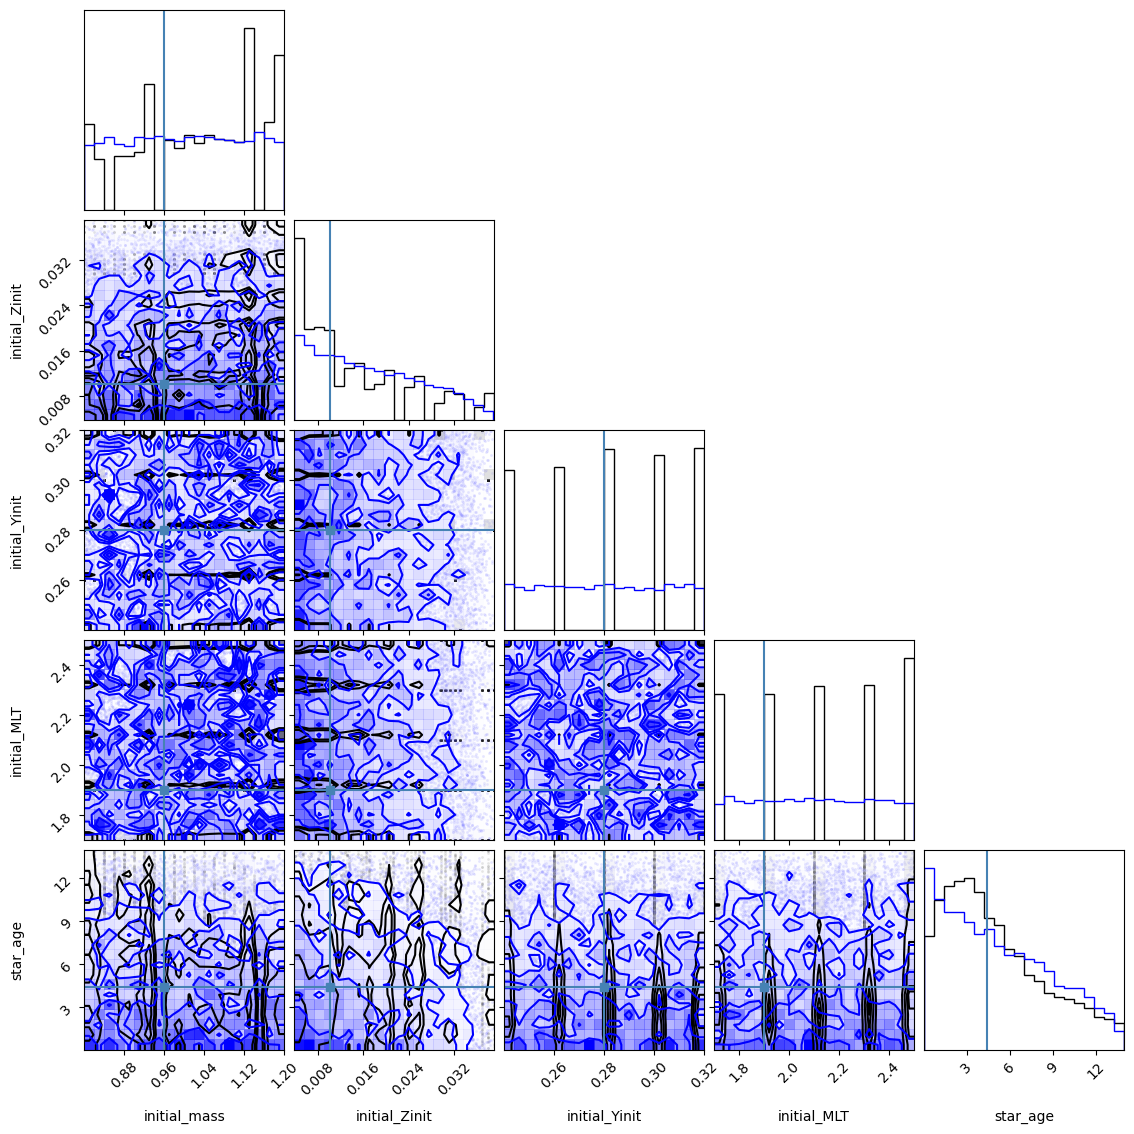

In [44]:
"""
Define priors
"""

def grid_uniform_prior(df, header):
    df_min = df[header].min()
    return scipy.stats.uniform(loc=df_min, scale=df[header].max()-df_min)

def uniform_prior(model_inps, header, scale=0.1):
    model_min = model_inps[header]*(1-scale)
    return scipy.stats.uniform(loc=model_min, scale=(model_inps[header]*(1+scale))-model_min)

def normal_prior(model_inps, header, scale=0.1):
    loc=model_inps[header].values[0]
    return scipy.stats.norm(loc=loc, scale=scale*loc)

def beta_prior(df, header,a=1,b=1):
    df_min = df[header].min()
    return scipy.stats.beta(loc=df_min, scale=df[header].max()-df_min, a=a, b=b)

mass_prior = grid_uniform_prior(df, "initial_mass")

Zinit_prior = beta_prior(df,"initial_Zinit",a=0.9, b=1.5)

Yinit_prior = grid_uniform_prior(df, "initial_Yinit")

MLT_prior = grid_uniform_prior(df, "initial_MLT")

age_prior = beta_prior(df, "star_age", a=0.9, b=1.5)


priors = [mass_prior,Zinit_prior, Yinit_prior, MLT_prior, age_prior]

figure = corner.corner(df[inputs].sample(n=10000), hist_kwargs={'density':True});

prior_samples = np.array([mass_prior.rvs(size=10000),Zinit_prior.rvs(size=10000), Yinit_prior.rvs(size=10000), MLT_prior.rvs(size=10000), age_prior.rvs(size=10000)]).T
corner.corner(prior_samples, truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='blue', fig=figure,hist_kwargs={'density':True});

In [45]:
pitchfork = emulator("nu6-40_elu_nonorm")

initial_mass range: [min = 0.8, max = 1.2]
initial_Zinit range: [min = 0.003869061466818601, max = 0.0389797119014747]
initial_Yinit range: [min = 0.24, max = 0.32]
initial_MLT range: [min = 1.7, max = 2.5]
star_age range: [min = 0.029664111540787196, max = 13.999973871651315]


In [55]:
"""
Define observed quantities and uncertainties
"""
obs = model_outs.values[0]
unc = np.array([100, 0.02, 0.0008] + [1 + 0.05*(np.abs(i-22))**2 for i in range(5,40)])
# 0.0006 in surface_Z from solar (~4.3%, Asplund 2020), increased to ~6%. Could try 10% too.
unc

array([1.000e+02, 2.000e-02, 8.000e-04, 1.545e+01, 1.380e+01, 1.225e+01,
       1.080e+01, 9.450e+00, 8.200e+00, 7.050e+00, 6.000e+00, 5.050e+00,
       4.200e+00, 3.450e+00, 2.800e+00, 2.250e+00, 1.800e+00, 1.450e+00,
       1.200e+00, 1.050e+00, 1.000e+00, 1.050e+00, 1.200e+00, 1.450e+00,
       1.800e+00, 2.250e+00, 2.800e+00, 3.450e+00, 4.200e+00, 5.050e+00,
       6.000e+00, 7.050e+00, 8.200e+00, 9.450e+00, 1.080e+01, 1.225e+01,
       1.380e+01, 1.545e+01])

In [56]:
"""
add noise to observed quantities
"""
def obs_noise(obs, unc):
    noisy_obs = np.empty(len(obs))
    idx = 0
    for ob in obs:
        noisy_obs[idx] = scipy.stats.norm(loc=ob, scale=unc[idx]).rvs()
        idx+=1

    return noisy_obs

noisy_obs = obs_noise(obs,unc)

print(noisy_obs-obs)
print(unc)

[ 1.23711417e+02  1.40492700e-02  2.17024208e-05 -4.28233991e+00
 -8.78135855e+00  8.03463750e+00 -9.99301400e+00  1.46970120e+01
  2.73491787e+00  1.06174994e+00  1.00063816e+00 -6.44881097e-01
  2.97265244e+00  1.34836391e-01 -2.26847538e+00  1.52906092e-01
 -3.48167408e-01  5.10844680e-01  1.84881193e+00 -1.96255234e+00
  9.94383292e-01 -6.68134762e-01  1.02495652e+00  5.02280887e-01
  2.16448552e+00  2.57754751e+00 -8.30485417e-01  6.73578037e+00
 -3.90817632e+00 -3.15363088e+00  4.78196308e+00  9.04377878e+00
 -3.35693657e+00  1.21113132e+00  1.20122187e+01  7.59542525e+00
  2.87154398e+01  1.06625579e+01]
[1.000e+02 2.000e-02 8.000e-04 1.545e+01 1.380e+01 1.225e+01 1.080e+01
 9.450e+00 8.200e+00 7.050e+00 6.000e+00 5.050e+00 4.200e+00 3.450e+00
 2.800e+00 2.250e+00 1.800e+00 1.450e+00 1.200e+00 1.050e+00 1.000e+00
 1.050e+00 1.200e+00 1.450e+00 1.800e+00 2.250e+00 2.800e+00 3.450e+00
 4.200e+00 5.050e+00 6.000e+00 7.050e+00 8.200e+00 9.450e+00 1.080e+01
 1.225e+01 1.380e+01 1.545

In [37]:
df_test = pd.read_hdf('/home/oxs235/repos/ojscutt/sl-pitchfork/test_data.h5', key='df')

def calc_Teff(luminosity, radius):
    return np.array(((luminosity.values*astropy.constants.L_sun) / (4*np.pi*constants.sigma*((radius.values*astropy.constants.R_sun)**2)))**0.25)

def rescale_preds(preds, df, column):
    if 'star_feh' in column:
        return (preds[column+"_std"]*df[column].std())+df[column].mean()
    else:
        return 10**((preds["log_"+column+"_std"]*df["log_"+column].std())+df["log_"+column].mean())

df_test['calc_Teff'] = calc_Teff(df_test['luminosity'], df_test['radius'])

preds=np.empty((len(outputs),len(df_test)))

for i in range(len(df_test)):
    pred = pitchfork.predict(np.array([df_test[inputs].iloc[i].values]))
    preds[:,i] = pred
    print(f'{i}', end='\r')

emulator_unc = scipy.stats.median_abs_deviation(df_test[['calc_Teff', 'luminosity', 'surface_Z'] + [f'nu_0_{i+1}' for i in range(5,40)]].values - preds.T)

print(len(unc))
print(len(emulator_unc))

combined_unc = np.sqrt(unc**2 + emulator_unc**2)
df_test['calc_Teff']

ValueError: operands could not be broadcast together with shapes (122434,38) (38,122434) 

In [51]:
emulator_unc = scipy.stats.median_abs_deviation(df_test[['calc_Teff', 'luminosity', 'surface_Z'] + [f'nu_0_{i+1}' for i in range(5,40)]].values - preds.T)

print(len(unc))
print(len(emulator_unc))

combined_unc = np.sqrt(unc**2 + emulator_unc**2)
emulator_unc

38
38


array([2.17481885e+00, 1.49321010e-03, 8.59179034e-06, 1.73638784e-01,
       2.12399586e-01, 2.17650317e-01, 1.88403741e-01, 2.10281198e-01,
       1.90846047e-01, 2.00662492e-01, 1.95457395e-01, 2.09331916e-01,
       2.04423746e-01, 2.19986605e-01, 2.18841383e-01, 2.25298850e-01,
       2.39063609e-01, 2.40144397e-01, 2.62088971e-01, 2.85301475e-01,
       2.95953541e-01, 3.01788287e-01, 3.20503871e-01, 3.46538864e-01,
       3.34202768e-01, 3.84616206e-01, 3.74860945e-01, 3.76383622e-01,
       4.16204839e-01, 3.97337028e-01, 4.49699833e-01, 4.44761959e-01,
       4.57332723e-01, 5.07610163e-01, 4.57920344e-01, 5.32071523e-01,
       5.03656818e-01, 5.52078221e-01])

iter: 7731 | +500 | bound: 83 | nc: 1 | ncall: 167439 | eff(%):  4.931 | loglstar:   -inf < -73.298 <    inf | logz: -88.069 +/-    nan | dlogz:  0.001 >  0.509                                      

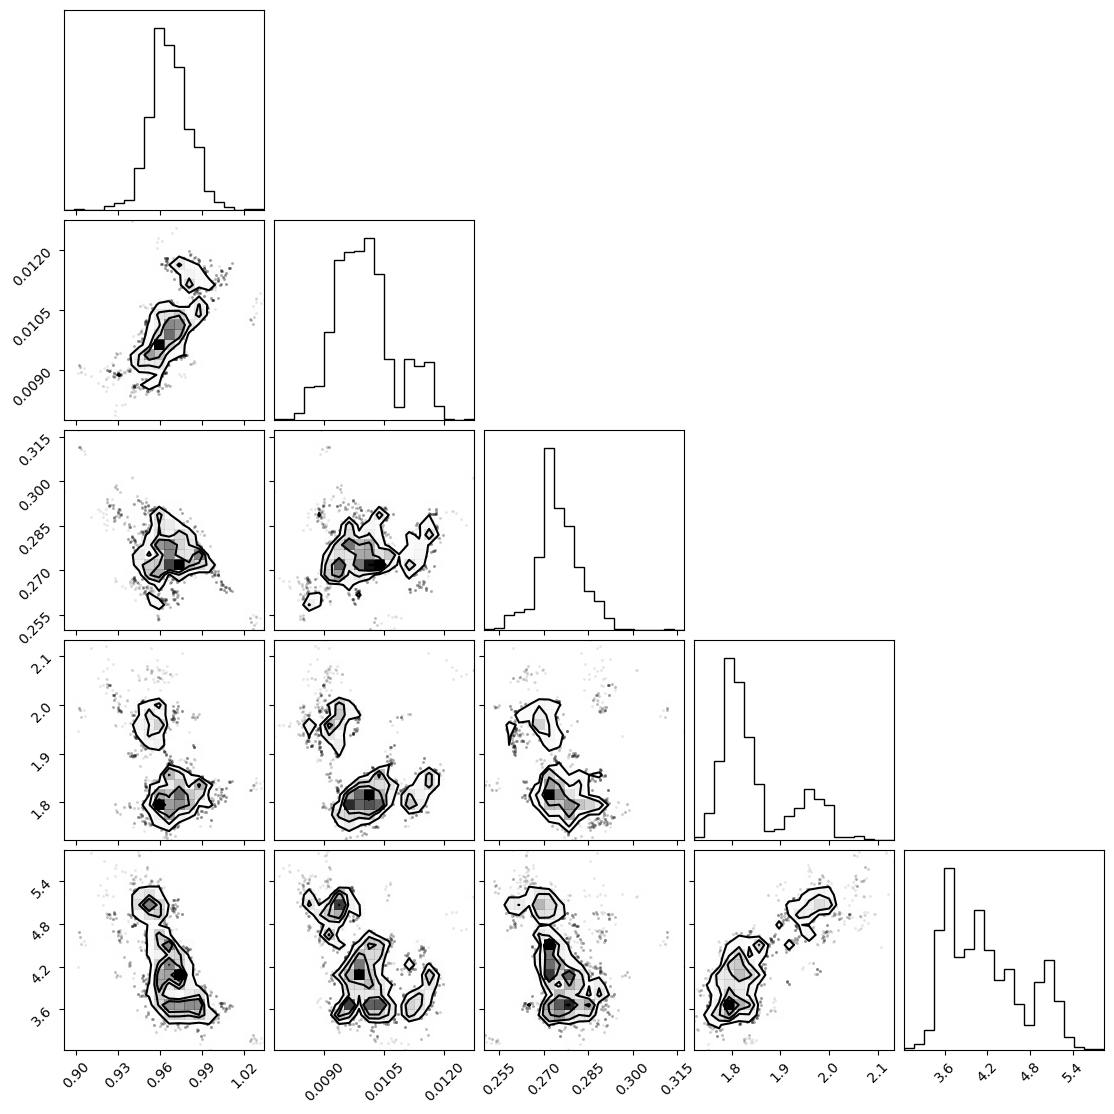

In [52]:
"""
run without emulator noise
"""

tic = time.time()
sampler = ns(priors=priors, observed_vals=obs, observed_unc=unc, pitchfork=pitchfork)
posterior = sampler(nlive=500,sample='rwalk', bound='multi')
toc = time.time()

corner.corner(posterior);

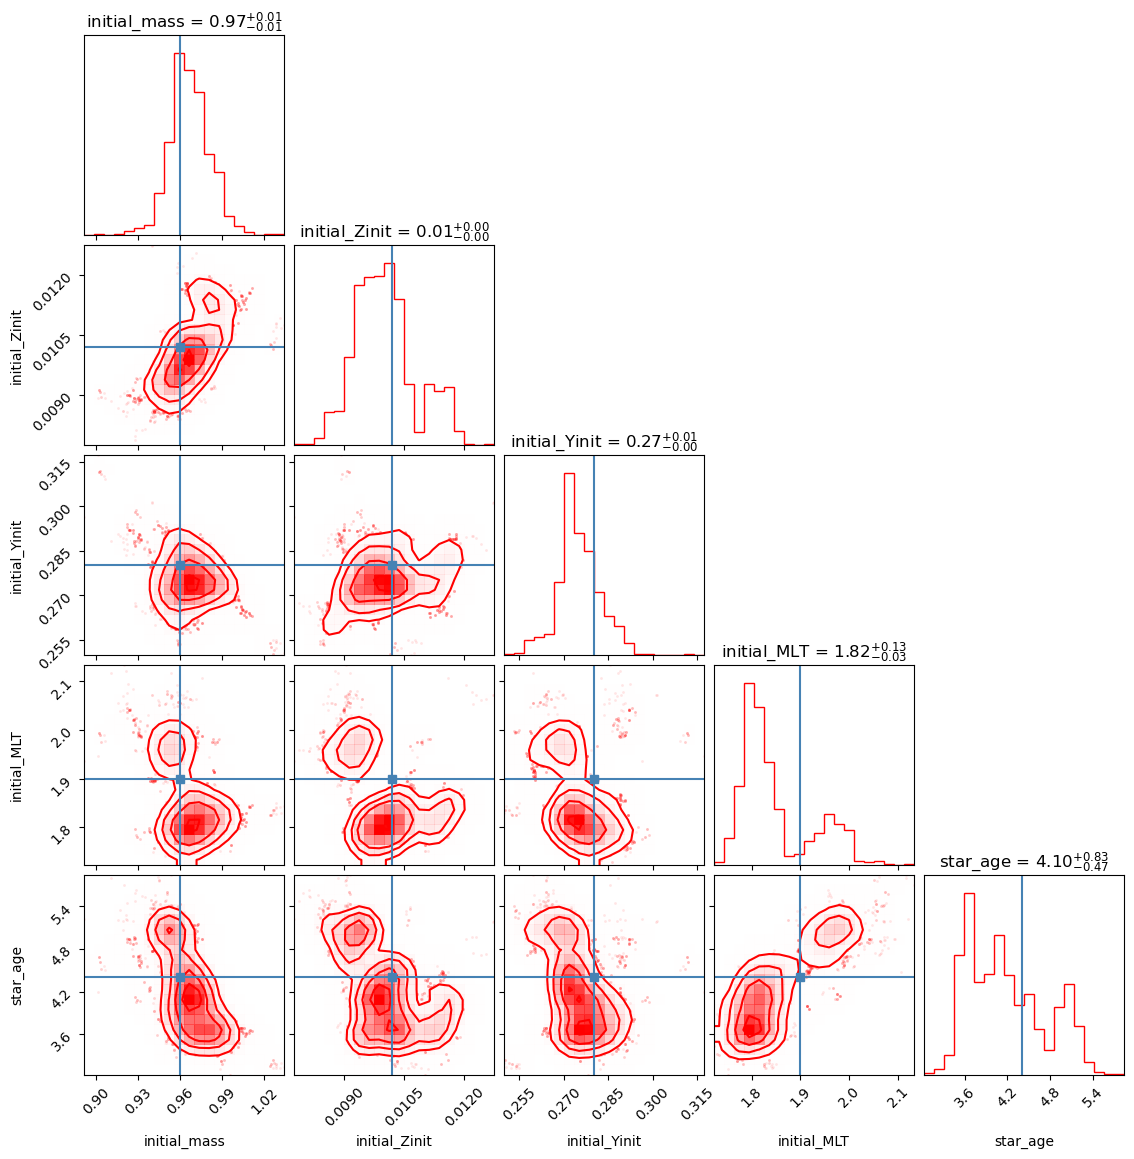

In [53]:
corner.corner(posterior, truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='red',show_titles=True,smooth=True);

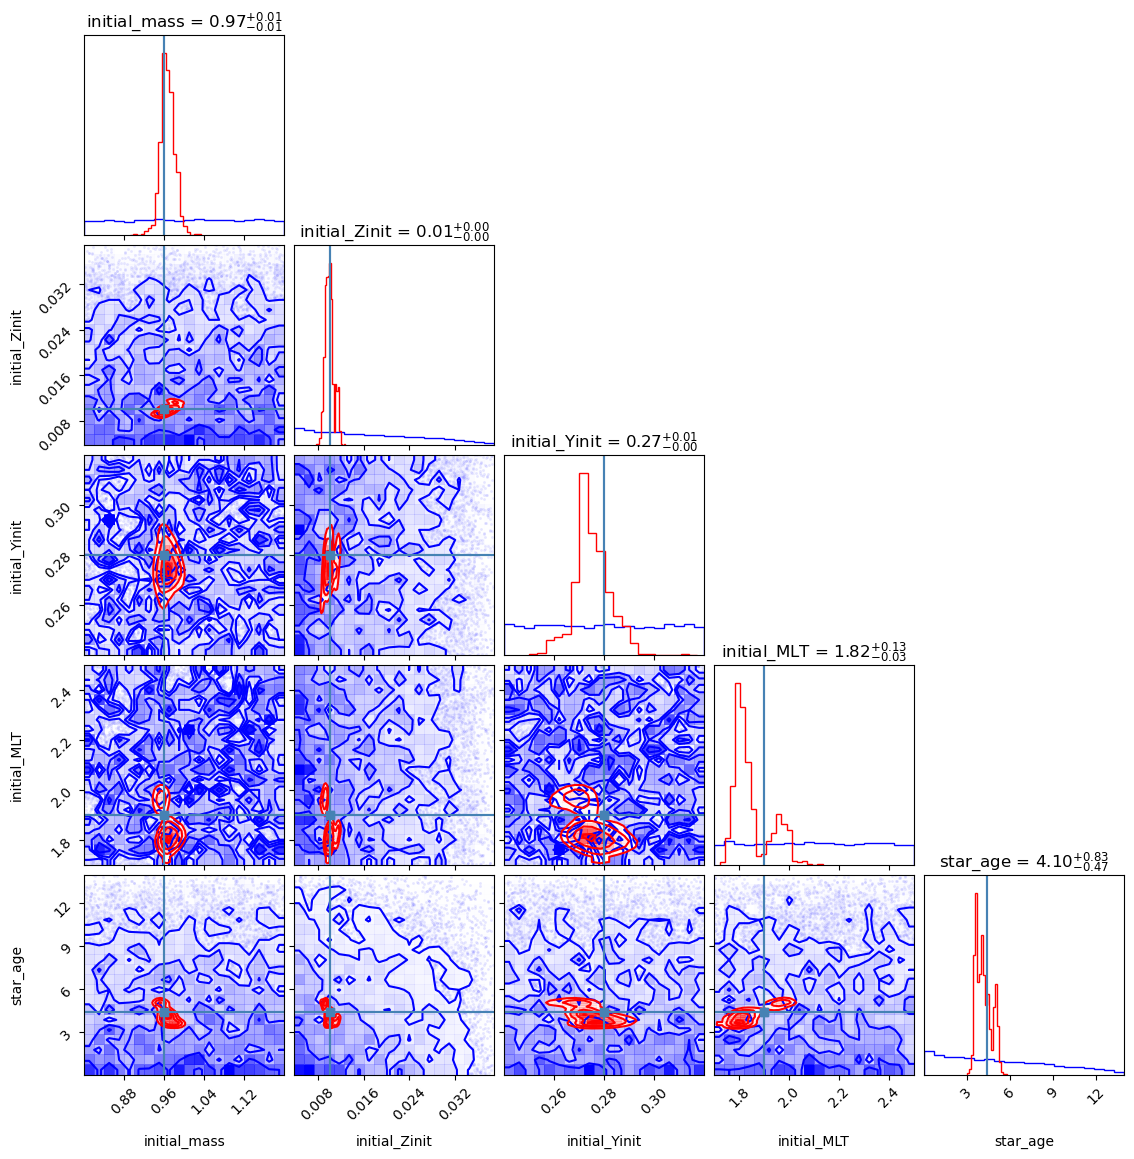

In [54]:
figure = corner.corner(prior_samples, truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='blue',hist_kwargs={'density':True})

corner.corner(posterior, truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='red',show_titles=True,smooth=True, fig=figure,hist_kwargs={'density':True});


iter: 4568 | +250 | bound: 97 | nc: 1 | ncall: 100648 | eff(%):  4.799 | loglstar:   -inf < -74.417 <    inf | logz: -91.292 +/-    nan | dlogz:  0.001 >  0.259                                      

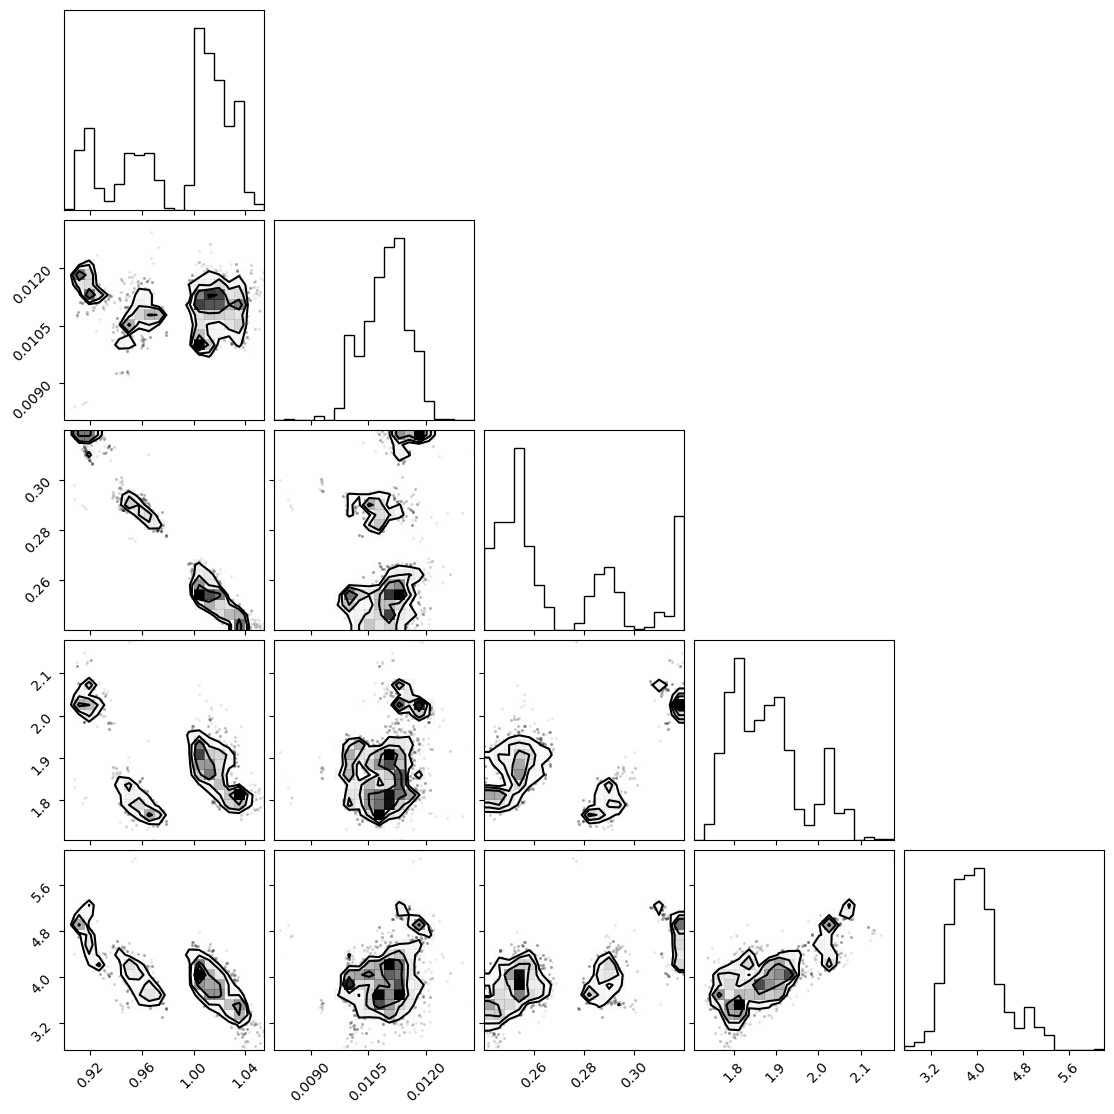

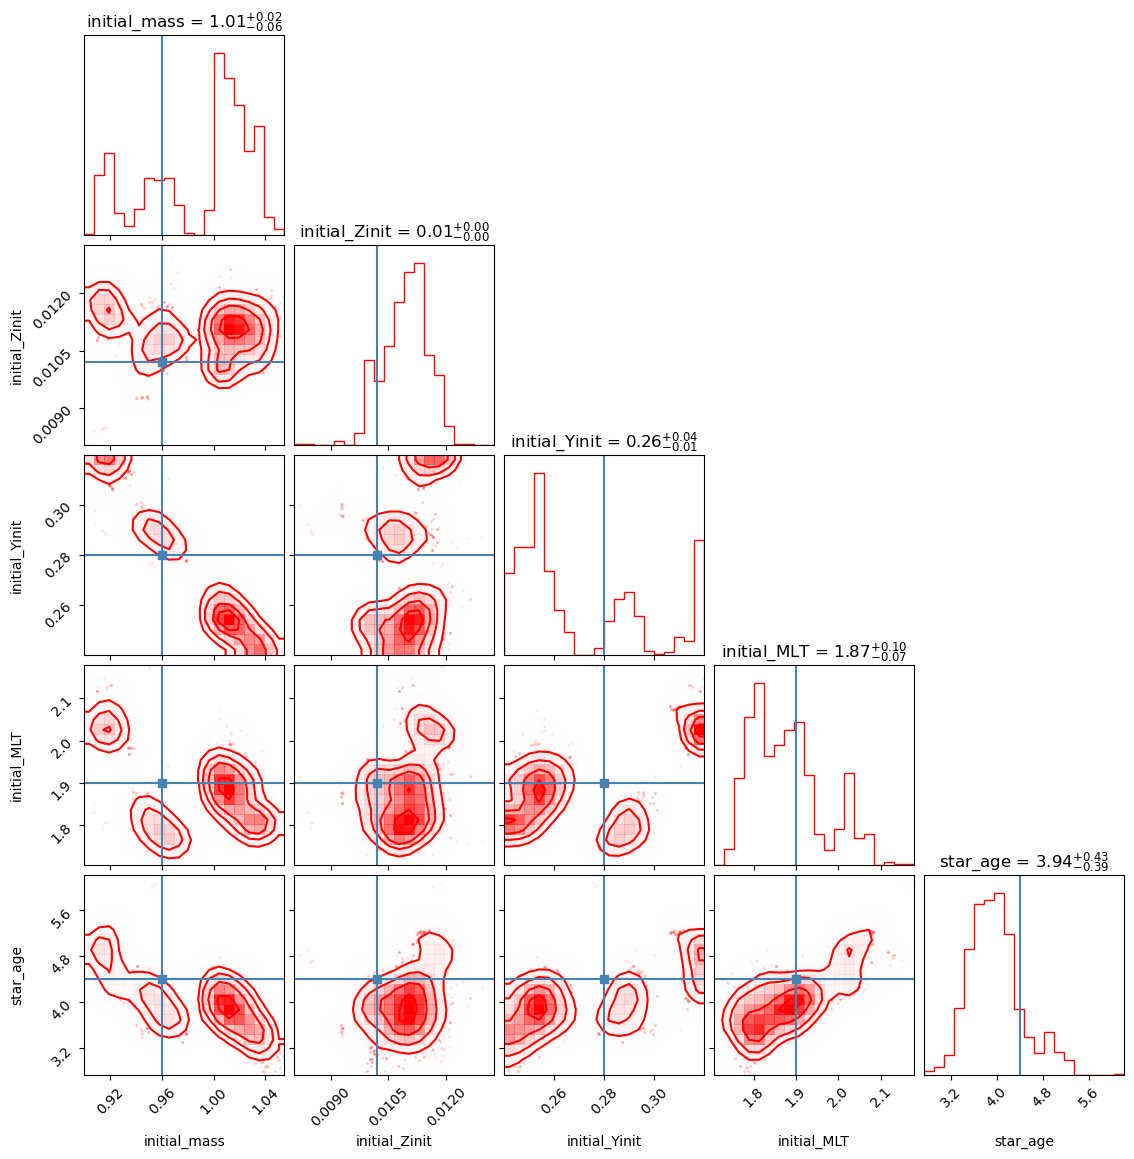

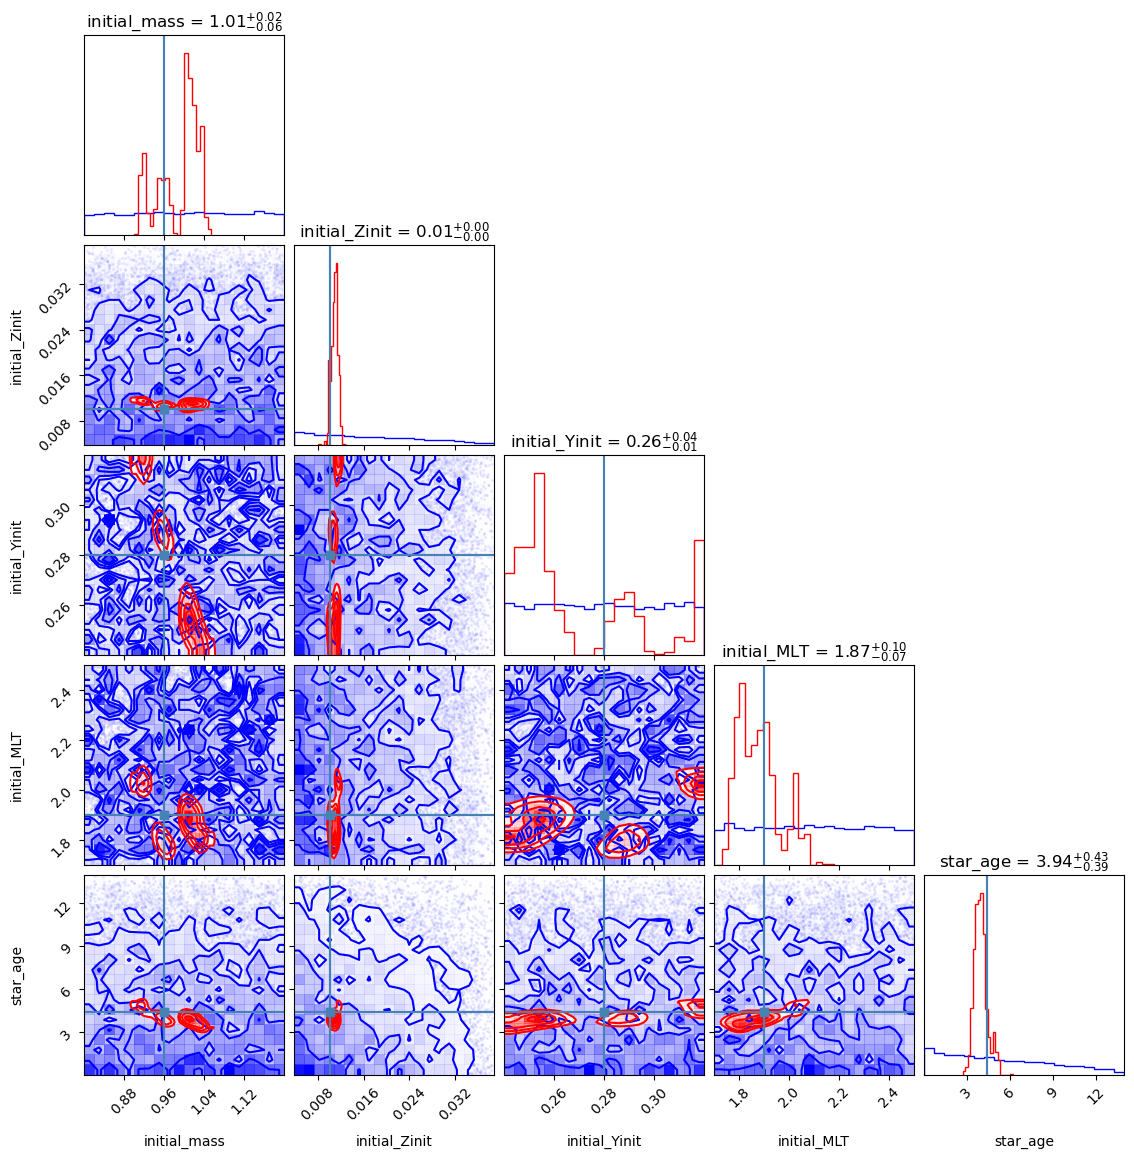

In [57]:
"""
run with emulator noise
"""

tic = time.time()
sampler = ns(priors=priors, observed_vals=obs, observed_unc=combined_unc, pitchfork=pitchfork)
posterior = sampler(nlive=250,sample='rwalk', bound='multi')
toc = time.time()

corner.corner(posterior);

corner.corner(posterior, truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='red',show_titles=True,smooth=True);

figure = corner.corner(prior_samples, truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='blue',hist_kwargs={'density':True})

corner.corner(posterior, truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='red',show_titles=True,smooth=True, fig=figure,hist_kwargs={'density':True});


In [ ]:
"""
run with obs noise added
"""
noisy_obs = obs_noise(obs,unc)

posteriors_dict = {'posterior_0' : posterior}

for i in range(1,5):
    print(f'current iteration: {i}', end='\r')
    noisy_obs = obs_noise(obs,unc)
    sampler = ns(priors=priors, observed_vals=noisy_obs, observed_unc=combined_unc, pitchfork=pitchfork)
    posterior_i = sampler(nlive=250,sample='rwalk', bound='multi')
    posteriors_dict[f'posterior_{i}'] = posterior_i
    

iter: 3776 | bound: 78 | nc: 25 | ncall: 80940 | eff(%):  4.665 | loglstar:   -inf < -105.567 <    inf | logz: -120.638 +/-    nan | dlogz:  3.673 >  0.259                                           

In [ ]:
idx = 0
for posterior_i in posteriors_dict:
    if idx == 0:
        figure = corner.corner(posteriors_dict[posterior_i], truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='black',show_titles=True,smooth=True,hist_kwargs={'density':True})
    elif idx == len(posteriors_dict)-1:
        corner.corner(posteriors_dict[posterior_i], truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='red',show_titles=True,smooth=True, fig=figure,hist_kwargs={'density':True})
    else:
        corner.corner(posteriors_dict[posterior_i], truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='black',show_titles=True,smooth=True, fig=figure,hist_kwargs={'density':True})
    idx+=1

In [ ]:
figure = corner.corner(prior_samples, truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='blue',hist_kwargs={'density':True})

idx = 0
for posterior_i in posteriors_dict:
    if idx == len(posteriors_dict)-1:
        corner.corner(posteriors_dict[posterior_i], truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='red',show_titles=True,smooth=True, fig=figure,hist_kwargs={'density':True})
    else:
        corner.corner(posteriors_dict[posterior_i], truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='black',show_titles=True,smooth=True, fig=figure,hist_kwargs={'density':True})
    idx+=1

In [ ]:
idx = 0
for posterior_i in posteriors_dict:
    if idx == 0:
        figure = corner.corner(posteriors_dict[posterior_i], truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='black',show_titles=True,smooth=True,hist_kwargs={'density':True})
    elif idx == len(posteriors_dict)-1:
        corner.corner(posteriors_dict[posterior_i], truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='red',show_titles=True,smooth=True, fig=figure,hist_kwargs={'density':True})
    else:
        corner.corner(posteriors_dict[posterior_i], truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='black',show_titles=True,smooth=True, fig=figure,hist_kwargs={'density':True})
    idx+=1

In [ ]:
figure = corner.corner(prior_samples, truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='blue',hist_kwargs={'density':True})

idx = 0
for posterior_i in posteriors_dict:
    if idx == len(posteriors_dict)-1:
        corner.corner(posteriors_dict[posterior_i], truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='red',show_titles=True,smooth=True, fig=figure,hist_kwargs={'density':True})
    else:
        corner.corner(posteriors_dict[posterior_i], truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='black',show_titles=True,smooth=True, fig=figure,hist_kwargs={'density':True})
    idx+=1

In [ ]:
len(posteriors_dict)

In [ ]:
figure = corner.corner(df[inputs].sample(n=posterior.shape[0]));
print(toc-tic)
prior_samples = np.array([mass_prior.rvs(size=posterior.shape[0]),Zinit_prior.rvs(size=posterior.shape[0]), Yinit_prior.rvs(size=posterior.shape[0]), MLT_prior.rvs(size=posterior.shape[0]), age_prior.rvs(size=posterior.shape[0])]).T
corner.corner(prior_samples, truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='blue', fig=figure);
corner.corner(posterior, truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='red', fig=figure);

In [ ]:
#prior_samples = np.array([mass_prior.rvs(size=posterior.shape[0]),Zinit_prior.rvs(size=posterior.shape[0]), Yinit_prior.rvs(size=posterior.shape[0]), MLT_prior.rvs(size=posterior.shape[0]), age_prior.rvs(size=posterior.shape[0])]).T
figure = corner.corner(prior_samples, truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='blue',hist_kwargs={'density':True});
corner.corner(posterior, truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='red', fig=figure,hist_kwargs={'density':True});
#hist_kwargs={'density'=True}

In [ ]:
corner.corner(posterior, truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='red',show_titles=True,smooth=True);

In [ ]:
%timeit pitchfork.predict([[0.1,0.1,0.1,0.1,0.1]])

In [ ]:
pitchfork.predict([[0.1,0.1,0.1,0.1,0.1]])

In [ ]:
import pickle
file_path = "pickle jar/nu6-40_elu_nonorm"

with open(file_path+".pkl", 'rb') as fp:
    emulator_dict = pickle.load(fp)
    
custom_objects = {"InversePCA": InversePCA(emulator_dict['custom_objects']['inverse_pca']['pca_comps'], emulator_dict['custom_objects']['inverse_pca']['pca_mean']),"WMSE": WMSE(emulator_dict['custom_objects']['WMSE']['weights'])}

model = tf.keras.models.load_model(file_path+".h5", custom_objects=custom_objects)

In [ ]:
%timeit model(np.array([[0.1,0.1,0.1,0.1,0.1]]))